# 📊 Crypto Trend Classifier with RSI, Fibonacci, XGBoost, and Streamlit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Load data
df = pd.read_csv(r'R:\GPT\AI-Pivot\Jupiter\btc.csv')
df.columns = df.columns.str.strip()
df.rename(columns={'Timestamp': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [2]:
df['Return'] = df['Close'].pct_change()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['Close'])

window = 20
df['Fib_Max'] = df['Close'].rolling(window=window).max()
df['Fib_Min'] = df['Close'].rolling(window=window).min()
df['Fib_38'] = df['Fib_Max'] - 0.382 * (df['Fib_Max'] - df['Fib_Min'])
df['Fib_62'] = df['Fib_Max'] - 0.618 * (df['Fib_Max'] - df['Fib_Min'])
df['In_Fib_Zone'] = ((df['Close'] >= df['Fib_62']) & (df['Close'] <= df['Fib_38'])).astype(int)

df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df = df.dropna()

C:\Users\papad\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


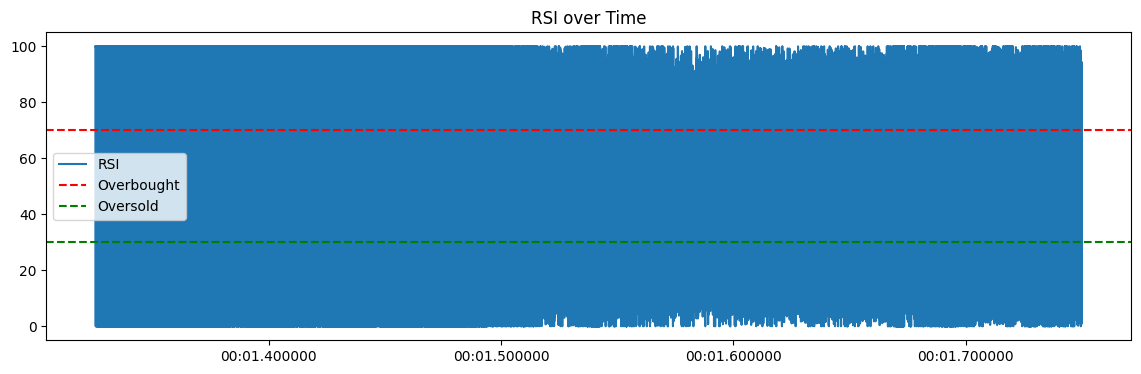

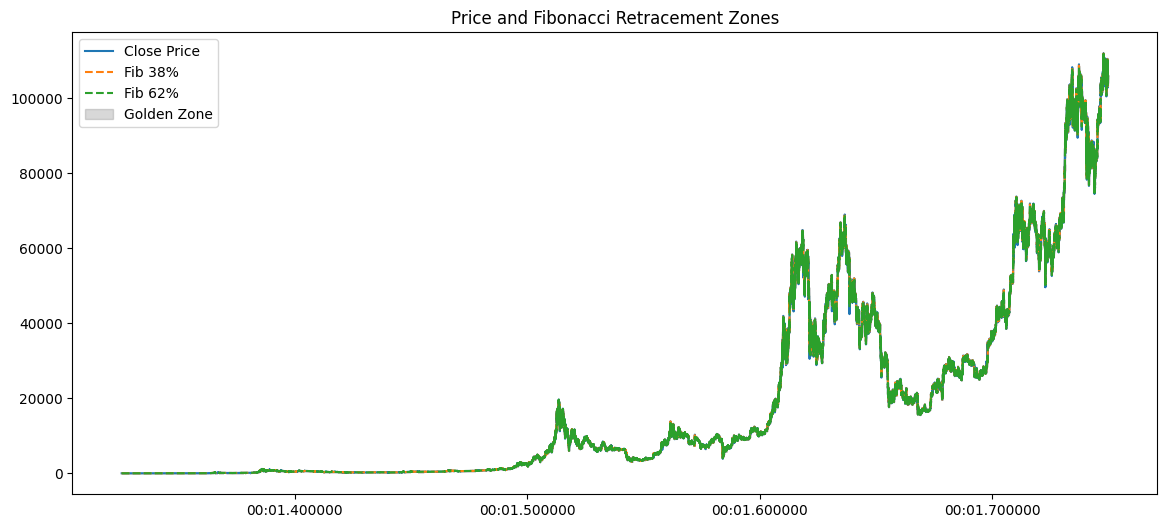

In [3]:
# Plot RSI
plt.figure(figsize=(14, 4))
plt.plot(df['Date'], df['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title('RSI over Time')
plt.legend()
plt.show()

# Plot Fibonacci zones on price
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['Fib_38'], label='Fib 38%', linestyle='--')
plt.plot(df['Date'], df['Fib_62'], label='Fib 62%', linestyle='--')
plt.fill_between(df['Date'], df['Fib_62'], df['Fib_38'], color='gray', alpha=0.3, label='Golden Zone')
plt.title('Price and Fibonacci Retracement Zones')
plt.legend()
plt.show()

In [4]:
from xgboost import XGBClassifier

X = df[['Return', 'RSI', 'In_Fib_Zone']]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

C:\Users\papad\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [21:12:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.613205539580495
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.88      0.73    799553
           1       0.52      0.21      0.30    520908

    accuracy                           0.61   1320461
   macro avg       0.58      0.54      0.52   1320461
weighted avg       0.59      0.61      0.56   1320461



In [5]:
import joblib
joblib.dump(model, 'xgb_crypto_model.pkl')

['xgb_crypto_model.pkl']

## 🧠 Streamlit Dashboard (Optional)
To turn this into a web app:

1. Create a file called `app.py` with the following:

```python
import streamlit as st
import pandas as pd
import joblib

# Load model and data
model = joblib.load('xgb_crypto_model.pkl')

st.title('Crypto Trend Predictor')
rsi = st.slider('RSI', 0, 100, 50)
fib = st.selectbox('In Fibonacci Golden Zone?', ['Yes', 'No'])
ret = st.number_input('Daily Return', value=0.0)

# Prepare input
features = pd.DataFrame([[ret, rsi, 1 if fib == 'Yes' else 0]], columns=['Return', 'RSI', 'In_Fib_Zone'])

if st.button('Predict'):
    pred = model.predict(features)
    st.write('📈 Price will go UP!' if pred[0] == 1 else '📉 Price will go DOWN or stay')
```

2. Save your model:

```python
import joblib
joblib.dump(model, 'xgb_crypto_model.pkl')
```

3. Run the app:

```bash
streamlit run app.py
```